<a href="https://colab.research.google.com/github/AmandeepSingh789/ML-Project/blob/main/Neural_Network_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

In [4]:
df = pd.read_csv("/content/wine-reviews.csv", usecols = ['country', 'description', 'points', 'price', 'variety', 'winery'])

In [5]:
df.head()


,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [6]:
# We will use the description to predict the points 

df=df.dropna(subset=["description","points"])
# Drops the null values 

In [7]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


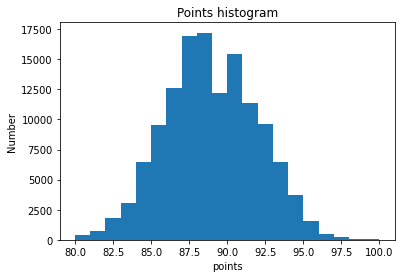

In [8]:
# Checking distribution of points
plt.hist(df.points,bins=20)
plt.title("Points histogram")
plt.xlabel("points")
plt.ylabel("N")
plt.show()

In [10]:
# Will try to classify reviews as low or high. below 90 or above 90.

df["label"] = (df.points >= 90).astype(int)
df= df[["description","label"]]

In [12]:
df.head()

,description,points,label
0,"Aromas include tropical fruit, broom, brimston...",87,0
1,"This is ripe and fruity, a wine that is smooth...",87,0
2,"Tart and snappy, the flavors of lime flesh and...",87,0
3,"Pineapple rind, lemon pith and orange blossom ...",87,0
4,"Much like the regular bottling from 2012, this...",87,0


In [17]:
# Splitting data
train,val,test = np.split(df.sample(frac=1),[int(0.8*len(df)),int(0.9*len(df))])

In [19]:
# Function to convert data to tensorflow dataset
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df["description"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [21]:
train_data=df_to_dataset(train)
valid_data=df_to_dataset(val)
test_data=df_to_dataset(test)

In [37]:
# Converting text to numbers
embedding= "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer= hub.KerasLayer(embedding,dtype=tf.string, trainable=True)

In [38]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.05884064, -0.12477646, -0.06413618, ..., -0.23933622,
        -0.22347707, -0.07425376],
       [ 0.3104115 , -0.19398884,  0.0693932 , ..., -0.01780244,
         0.18312871, -0.03725239],
       [ 0.04953431,  0.06659806,  0.23604213, ...,  0.03260303,
        -0.1140773 , -0.22729328],
       ...,
       [ 0.57897437, -0.05506517, -0.19701684, ...,  0.0489367 ,
        -0.0583218 ,  0.12964502],
       [ 0.27833685, -0.5460846 ,  0.0483594 , ...,  0.07196293,
        -0.09541789,  0.05900387],
       [ 0.36792555,  0.17869388, -0.26068568, ..., -0.02497496,
        -0.23267074,  0.03991748]], dtype=float32)>

In [39]:
model =tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16,activation="relu"))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16,activation="relu"))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1,activation="sigmoid"))

In [40]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [41]:
model.evaluate(train_data)

102/102 [==============================] - 2s 18ms/step - loss: 0.6751 - accuracy: 0.6217


[0.6751074194908142, 0.621749222278595]

In [42]:
model.evaluate(valid_data)

13/13 [==============================] - 1s 52ms/step - loss: 0.6761 - accuracy: 0.6175


[0.6761335134506226, 0.6174501776695251]

In [43]:
history = model.fit(train_data,epochs=5,validation_data=valid_data)

Epoch 1/5
102/102 [==============================] - 63s 603ms/step - loss: 0.6169 - accuracy: 0.6576 - val_loss: 0.4893 - val_accuracy: 0.7827
Epoch 2/5
102/102 [==============================] - 64s 624ms/step - loss: 0.4599 - accuracy: 0.7864 - val_loss: 0.3920 - val_accuracy: 0.8247
Epoch 3/5
102/102 [==============================] - 61s 598ms/step - loss: 0.3958 - accuracy: 0.8294 - val_loss: 0.3712 - val_accuracy: 0.8307
Epoch 4/5
102/102 [==============================] - 61s 601ms/step - loss: 0.3614 - accuracy: 0.8474 - val_loss: 0.3644 - val_accuracy: 0.8337
Epoch 5/5
102/102 [==============================] - 61s 601ms/step - loss: 0.3386 - accuracy: 0.8588 - val_loss: 0.3676 - val_accuracy: 0.8355


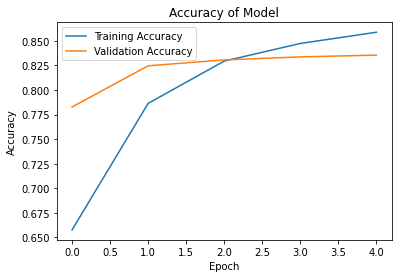

In [44]:
plt.plot(history.history['accuracy'],label="Training Accuracy")
plt.plot(history.history['val_accuracy'],label="Validation Accuracy")
plt.title("Accuracy of Model")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

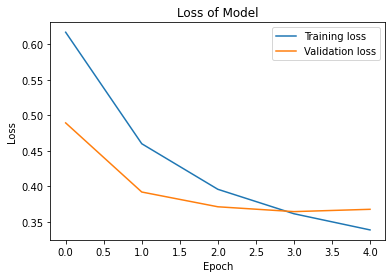

In [45]:
plt.plot(history.history['loss'],label="Training loss")
plt.plot(history.history['val_loss'],label="Validation loss")
plt.title("Loss of Model")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [46]:
model.evaluate(test_data)

13/13 [==============================] - 1s 103ms/step - loss: 0.3647 - accuracy: 0.8371


[0.3646640181541443, 0.8370518684387207]

#LSTM


In [47]:
encoder=tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text,label: text))

In [48]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'flavors', 'in', 'it', 'to', 'its', 'on', 'fruit', 'aromas',
       'palate', 'that'], dtype='<U17')

In [51]:
model= tf.keras.Sequential([
                            encoder,
                            tf.keras.layers.Embedding(
                                input_dim=len(encoder.get_vocabulary()),
                                output_dim=32,
                                mask_zero=True
                            ),
                            tf.keras.layers.LSTM(32),
                            tf.keras.layers.Dense(32,activation="relu"),
                            tf.keras.layers.Dropout(0.4),
                            tf.keras.layers.Dense(1,activation="sigmoid")
])

In [52]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [53]:
model.evaluate(train_data)

102/102 [==============================] - 24s 179ms/step - loss: 0.6933 - accuracy: 0.4754


[0.6933091878890991, 0.47536930441856384]

In [54]:
model.evaluate(valid_data)

13/13 [==============================] - 2s 160ms/step - loss: 0.6933 - accuracy: 0.4700


[0.6933175325393677, 0.4700315594673157]

In [55]:
history=model.fit(train_data,epochs=5,validation_data=valid_data)

Epoch 1/5
102/102 [==============================] - 75s 655ms/step - loss: 0.5474 - accuracy: 0.7103 - val_loss: 0.3745 - val_accuracy: 0.8249
Epoch 2/5
102/102 [==============================] - 50s 489ms/step - loss: 0.3667 - accuracy: 0.8358 - val_loss: 0.3479 - val_accuracy: 0.8420
Epoch 3/5
102/102 [==============================] - 50s 487ms/step - loss: 0.3510 - accuracy: 0.8434 - val_loss: 0.3437 - val_accuracy: 0.8459
Epoch 4/5
102/102 [==============================] - 47s 459ms/step - loss: 0.3438 - accuracy: 0.8462 - val_loss: 0.3451 - val_accuracy: 0.8407
Epoch 5/5
102/102 [==============================] - 48s 465ms/step - loss: 0.3394 - accuracy: 0.8481 - val_loss: 0.3423 - val_accuracy: 0.8436


In [56]:
model.evaluate(test_data)

13/13 [==============================] - 4s 329ms/step - loss: 0.3376 - accuracy: 0.8459


[0.33759385347366333, 0.8458993434906006]